In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.tsa.api import Holt

from pandas.plotting import register_matplotlib_converters
from datetime import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt

from datetime import timedelta, datetime
import requests

import env

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('saas.csv')

In [3]:
df.head()

,Month_Invoiced,Customer_Id,Invoice_Id,Subscription_Type,Amount
0,2014-01-31,1000000,5000000,0.0,0.0
1,2014-01-31,1000001,5000001,2.0,10.0
2,2014-01-31,1000002,5000002,0.0,0.0
3,2014-01-31,1000003,5000003,0.0,0.0
4,2014-01-31,1000004,5000004,1.0,5.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 790458 entries, 0 to 790457
Data columns (total 5 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Month_Invoiced     790458 non-null  object 
 1   Customer_Id        790458 non-null  int64  
 2   Invoice_Id         790458 non-null  int64  
 3   Subscription_Type  790458 non-null  float64
 4   Amount             790458 non-null  float64
dtypes: float64(2), int64(2), object(1)
memory usage: 30.2+ MB


In [5]:
def prep_data(df):
    return df.assign(ds = pd.to_datetime(df.Month_Invoiced)).\
            sort_values('ds').\
            groupby(['ds'])[['Amount']].sum()

In [12]:
df = prep_data(df)

In [16]:
df

,Amount
ds,
2014-01-31,35850.0
2014-02-28,37190.0
2014-03-31,38295.0
2014-04-30,39255.0
2014-05-31,40355.0
2014-06-30,41255.0
2014-07-31,42170.0
2014-08-31,43210.0
2014-09-30,44075.0


In [17]:
train = df.loc[:'2015']
validate = df.loc['2016']
test = df.loc['2017']

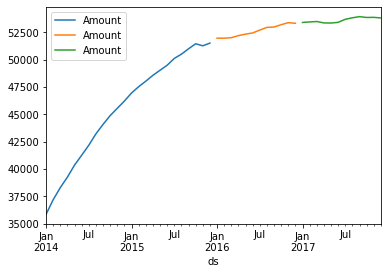

In [19]:
ax = train.plot(label='train')
validate.plot(ax=ax, label='validate')
test.plot(ax=ax, label='test')
plt.legend()

In [20]:
def evaluate(target_var):
    '''
    the evaluate function will take in the actual value in validate 
    and the predicted values
    and compute the mean_squared_error and then take the square root
    and round to 0 decimals.
    It will return the rmse, an integer.
    '''
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])),0)
    return rmse

In [21]:
# plot and evaluate: plot
def plot_and_eval(target_var):
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label = 'Train', linewidth = 1)
    plt.plot(validate[target_var], label = 'Validate', linewidth = 1)
    plt.plot(yhat_df[target_var])
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, '-- RMSE: {:.0f}'.format(rmse))
    plt.show()

In [22]:
# Create the empty dataframe with model_type, target_var, rmse
eval_df = pd.DataFrame(columns = ['model_type','target_var','rmse'])

In [23]:
# check out the data frame
eval_df

,model_type,target_var,rmse


In [24]:
# Define function to store rmse for comparison purposes

def append_eval_df(model_type, target_var):
    '''
    this function is going to take in the model_type as a string, the target variable as a string,
    and run the evaluate() function to compute the rmse,
    and append to the data frame a row with the model_type, target_var, and rmse.
    It will return the new dataframe.
    '''
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var], 'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index=True)

### Simple Average

Take the simple average of historical values and use that value to predict future values.   

This is a good option for an initial baseline. Every future datapoint (those in 'test') will be assigned the same value, and that value will be the overall mean of the values in train. 

**Make Predictions**

In [27]:
amount = round(train['Amount'].mean(),2)

def make_predictions(amount):
    yhat_df = pd.DataFrame({'Amount': [amount]}, index = validate.index)
    return yhat_df

In [28]:
yhat_df = make_predictions(amount)
yhat_df

,Amount
ds,
2016-01-31,45568.54
2016-02-29,45568.54
2016-03-31,45568.54
2016-04-30,45568.54
2016-05-31,45568.54
2016-06-30,45568.54
2016-07-31,45568.54
2016-08-31,45568.54
2016-09-30,45568.54


**Plot Actual vs. Predicted Values**

Now, let's plot and evaluate the performance of our time series model using **Simple Average**

Amount -- RMSE: 7063


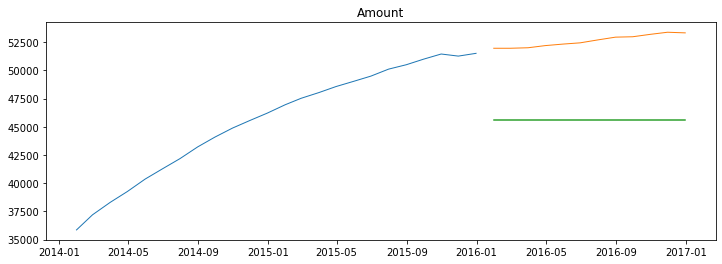

In [29]:
for col in train.columns:
    plot_and_eval(col)

In [30]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'simple_average', target_var = col)

In [31]:
eval_df

,model_type,target_var,rmse
0,simple_average,Amount,7063.0


### Moving Average


**Make Predictions**

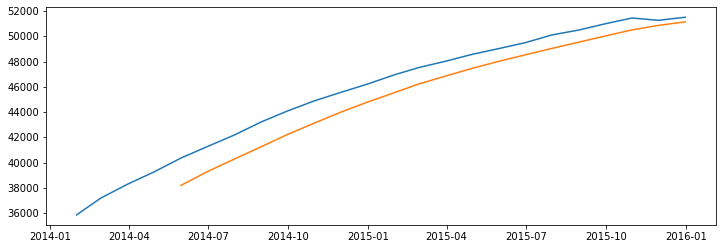

In [42]:
plt.figure(figsize=(12,4))
plt.plot(train['Amount'])
plt.plot(train['Amount'].rolling(5).mean())
plt.show()

In [43]:
period = 5
amount = round(train['Amount'].rolling(period).mean().iloc[-1],0)
print(amount)

51138.0


In [44]:
# create a new yhat data frame with the forecast through validate dates.

yhat_df = make_predictions(amount)
yhat_df.head(3)

,Amount
ds,
2016-01-31,51138.0
2016-02-29,51138.0
2016-03-31,51138.0


Amount -- RMSE: 1563


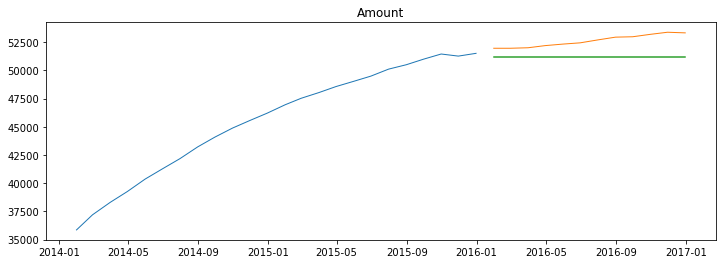

In [45]:
for col in train.columns:
    plot_and_eval(col)

In [46]:
for col in train.columns:
    eval_df = append_eval_df(model_type = '5 period moving average', target_var = col)

In [47]:
eval_df

,model_type,target_var,rmse
0,simple_average,Amount,7063.0
1,5 period moving average,Amount,1563.0


### Holt's Linear Trend

Exponential smoothing applied to both the average and the trend (slope).  

- $\alpha$ / smoothing_level: smoothing parameter for mean. Values closer to 1 will have less of a smoothing effect and will give greater weight to recent values.   
- $\beta$ / smoothing_slope: smoothing parameter for the slope. Values closer to 1 will give greater weight to recent slope/values. 


**Seasonal Decomposition**

First, let's take a look at the seasonal decomposition for each target. 

Amount 



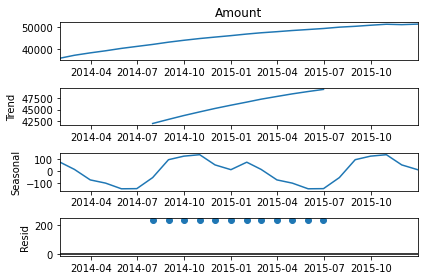

In [49]:
import statsmodels.api as sm

for col in train.columns:
    print(col, '\n')
    _ = sm.tsa.seasonal_decompose(train[col]).plot()
    plt.show()